In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs6353/assignments/assignment2/'
FOLDERNAME = 'cs6353/assignments/assignment2/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs6353/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

# Install requirements from colab_requirements.txt
# TODO: Please change your path below to the colab_requirements.txt file
! python -m pip install -r /content/drive/My\ Drive/$FOLDERNAME/colab_requirements.txt

Mounted at /content/drive
/content/drive/My Drive/cs6353/assignments/assignment2/cs6353/datasets
--2024-12-06 01:10:00--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  51.0MB/s    in 3.4s    

2024-12-06 01:10:04 (47.4 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1
/content/drive/My Drive/cs6353/assignments/assignment2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://utah.instructure.com/courses/919972/assignments/12590082) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [ ]:
# Run some setup code for this notebook.
from __future__ import print_function
import random
import numpy as np
from cs6353.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [ ]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs6353/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


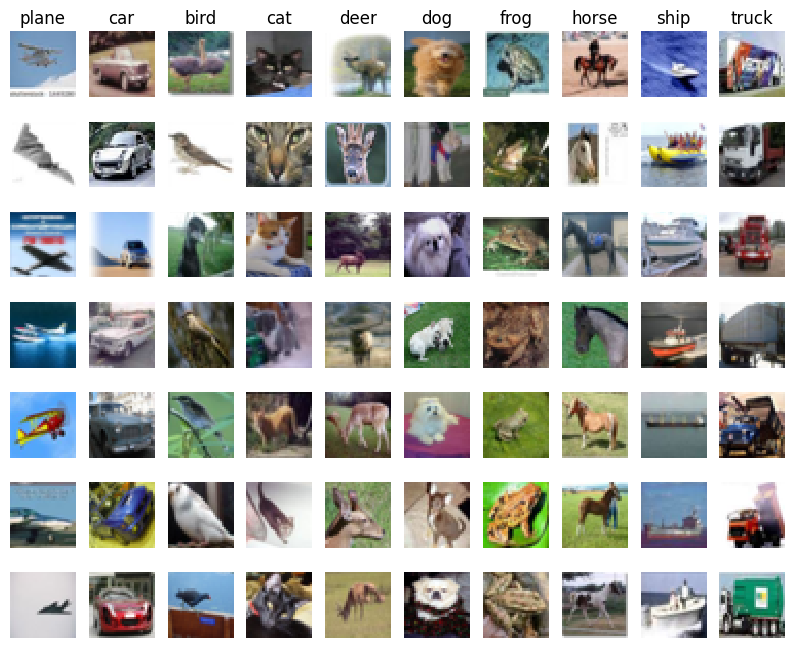

In [ ]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [ ]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Ensure we do not exceed the available size of X_train
if X_train.shape[0] < num_training + num_validation:
    num_training = X_train.shape[0] - num_validation


# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[list(mask)]  # Convert range to list to avoid slicing issues
y_val = y_train[list(mask)]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[list(mask)]  # Convert range to list to avoid slicing issues
y_train = y_train[list(mask)]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
X_test = X_test[:num_test]
y_test = y_test[:num_test]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)


Train data shape:  (48000, 3074)
Train labels shape:  (48000,)
Validation data shape:  (1000, 3074)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3075)
Test labels shape:  (1000,)


In [ ]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# Function to add the bias term only if it's not already present
def add_bias_term(X):
    if X.shape[1] == 3074:  # Check if bias term is missing
        return np.hstack([X, np.ones((X.shape[0], 1))])
    return X  # Return as-is if bias term is already added

# Add the bias term to all datasets
X_train = add_bias_term(X_train)
X_val = add_bias_term(X_val)
X_test = add_bias_term(X_test)
X_dev = add_bias_term(X_dev)

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (48000, 3076)
Validation data shape:  (1000, 3076)
Test data shape:  (1000, 3076)
dev data shape:  (500, 3076)


[-0.04239371 -0.02657781 -0.01770663 -0.04159779 -0.02608418 -0.01818793
 -0.06553231 -0.04908929 -0.03342432 -0.0712432 ]


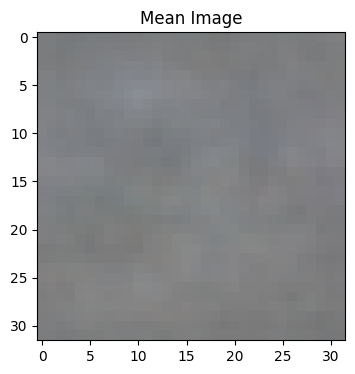

In [ ]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data

mean_image = np.mean(X_train[:, :-1], axis=0)  # Exclude the bias term
print(mean_image[:10])  # Print a few of the elements

# Rescale the mean image to [0, 255] for visualization
mean_image_rescaled = 255.0 * (mean_image - np.min(mean_image)) / (np.max(mean_image) - np.min(mean_image))

# Visualize the mean image
plt.figure(figsize=(4, 4))
plt.imshow(mean_image_rescaled[:3072].reshape((32, 32, 3)).astype('uint8'))  # Use only pixel values
plt.title("Mean Image")
plt.show()

In [ ]:
# second: subtract the mean image from train and test data
X_train[:, :-1] -= mean_image  # Exclude the bias term while subtracting the mean
X_val[:, :-1] -= mean_image
X_test[:, :-1] -= mean_image
X_dev[:, :-1] -= mean_image

In [ ]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(48000, 3077) (1000, 3077) (1000, 3077) (500, 3077)


## SVM Classifier

Your code for this section will all be written inside **cs6353/classifiers/linear_svm.py**.

As you can see, we have prefilled the function `svm_loss_naive` which uses for loops to evaluate the multiclass SVM loss function.

In [ ]:
# Evaluate the naive implementation of the loss we provided for you:
from cs6353.classifiers.linear_svm import svm_loss_naive
import time

# Fix the bias term for all datasets to ensure it's added only once
def ensure_bias_term(X):
    if X.shape[1] == 3074:  # Add bias term if missing
        return np.hstack([X, np.ones((X.shape[0], 1))])
    elif X.shape[1] > 3075:  # Fix if multiple bias terms were added
        return np.hstack([X[:, :3074], np.ones((X.shape[0], 1))])
    return X  # Return as-is if already correct

# Apply the fix
X_train = ensure_bias_term(X_train)
X_val = ensure_bias_term(X_val)
X_test = ensure_bias_term(X_test)
X_dev = ensure_bias_term(X_dev)




# generate a random SVM weight matrix of small numbers
W = np.random.randn(X_dev.shape[1], 10) * 0.0001 # Match the number of features in X_dev

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.131110


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [ ]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs6353.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 7.627152 analytic: 7.627152, relative error: 7.930395e-11
numerical: -4.559018 analytic: -4.559018, relative error: 9.141636e-12
numerical: 23.104633 analytic: 23.104633, relative error: 1.024560e-11
numerical: 6.524187 analytic: 6.524187, relative error: 1.198299e-11
numerical: 44.017363 analytic: 43.940278, relative error: 8.763782e-04
numerical: 0.460760 analytic: 0.460760, relative error: 2.001671e-09
numerical: 7.207787 analytic: 7.207787, relative error: 4.673573e-11
numerical: -0.406687 analytic: -0.406687, relative error: 4.213492e-10
numerical: -5.603932 analytic: -5.603932, relative error: 9.727154e-11
numerical: 25.428283 analytic: 25.378575, relative error: 9.783778e-04
numerical: -12.946339 analytic: -12.946339, relative error: 4.031426e-11
numerical: 17.912832 analytic: 17.912832, relative error: 5.833780e-12
numerical: 34.680593 analytic: 34.680593, relative error: 4.300267e-12
numerical: 5.969931 analytic: 5.969931, relative error: 2.150919e-11
numerical: -4.

### Inline Question 1:
It is possible that once in a while a dimension in the gradient check will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *fill this in.

**PART1:** Why might a dimension in the gradient check not match exactly?

Sometimes, when you compare the numerically computed gradient to the analytically computed gradient, the two won't match perfectly. This can happen for two main reasons:

1. Numerical Precision Issues: Since Gradient checking uses a numerical approximation based on small changes to the weights, like this:

    δf/δW  ≈ (f(W+h)-f(W-h))/2h.

Thus if h (the step size) is too small, rounding errors in the floating-point arithmetic can mess up the result. These errors don't usually mean your gradient is wrong but are just a limitation of the numerical method


2. Non-Differentiability: The SVM loss function has "kinks" at certain points where it switches between being flat (loss is zero) and having a positive slope (loss is greater than zero). These kinks occur when the margin is exactly zero, as in:

    margin = max\(0, sⱼ - sᵧᵢ  + δ)

At these points, the function is not smooth, and its gradient is undefined. Numerical methods might give you a value, but there's no single "correct" answer here because the gradient doesn’t technically exist.

**Part 2:** Should this be a reason for concern?

I don't believe so small mismatches are common and expected due to numerical precision and the nature of the loss function. They’re only a problem if they happen in many places or the errors are large. If most dimensions match well and the relative errors are small, your gradient implementation is likely fine.


**Part 3:** Can you give a simple example where gradient checks fail?


Let's look at the one-dimensional function:

    f(x) = max(0,x)

    * if x > 0, gradient is f'(x) = 1.
    * if x < 0, gradient f'(x) = 0.
    * However at x = 0, gradient would be undefined due to the function suddenly switches from flat to slop.

Thus, if we use gradient at x = 0. We would have:

    f'(x) ≈ (f(h) - f(-h))/2h = (h-0)/2h ≈ 0.5

As a reuslt the numerical gradient 0.5 would not match with the analytical gradient (undefined), which shows why the check might fail.

**Part 4:** How does the margin size affect this?

  * Larger Margin (𝛿 > 1): The function becomes smoother because the margin is less likely to reach zero. Discrepancies in gradient checks become less frequent.



  * Smaller Margin (δ<1): The function has more kinks because the margin reaches zero more often. This makes discrepancies more frequent.















In [ ]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs6353.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.131110e+00 computed in 0.226418s
Vectorized loss: 9.131110e+00 computed in 0.026713s
difference: -0.000000


In [ ]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.141822s
Vectorized loss and gradient: computed in 0.010362s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.  Your code for this part will be written inside `cs6353/classifiers/linear_classifier.py`.

In [ ]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs6353.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 792.811469
iteration 100 / 1500: loss 288.278937
iteration 200 / 1500: loss 107.876980
iteration 300 / 1500: loss 43.021308
iteration 400 / 1500: loss 18.195767
iteration 500 / 1500: loss 9.912935
iteration 600 / 1500: loss 7.101565
iteration 700 / 1500: loss 5.658936
iteration 800 / 1500: loss 5.321759
iteration 900 / 1500: loss 5.943075
iteration 1000 / 1500: loss 5.132132
iteration 1100 / 1500: loss 4.993031
iteration 1200 / 1500: loss 5.354704
iteration 1300 / 1500: loss 5.622773
iteration 1400 / 1500: loss 5.562087
That took 11.217257s


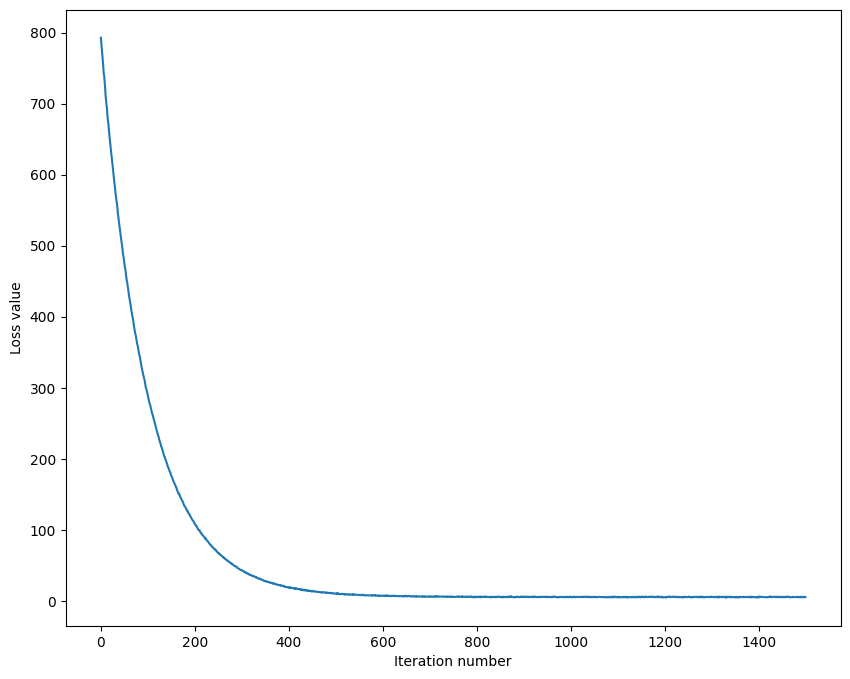

In [ ]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [ ]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.367792
validation accuracy: 0.335000


In [115]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [0.5e-7, 1e-7, 2e-7]
regularization_strengths = [2.0e4, 2.5e4, 3.0e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

# Iterate over all combinations of learning rates and regularization strengths
for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=1500, verbose=False)  # Use lr and reg

        y_train_pred = svm.predict(X_train)
        train_accuracy = np.mean(y_train_pred == y_train)

        y_val_pred = svm.predict(X_val)
        val_accuracy = np.mean(y_val_pred == y_val)

        results[(lr, reg)] = (train_accuracy, val_accuracy)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_svm = svm


################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in results:
    train_acc, val_acc = results[(lr, reg)]
    print(f'lr {lr:e} reg {reg:e} train accuracy: {train_acc:.3f} val accuracy: {val_acc:.3f}')

print(f'Best validation accuracy: {best_val:.3f}')

lr 5.000000e-08 reg 2.000000e+04 train accuracy: 0.375 val accuracy: 0.346
lr 5.000000e-08 reg 2.500000e+04 train accuracy: 0.373 val accuracy: 0.348
lr 5.000000e-08 reg 3.000000e+04 train accuracy: 0.366 val accuracy: 0.342
lr 1.000000e-07 reg 2.000000e+04 train accuracy: 0.373 val accuracy: 0.342
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.372 val accuracy: 0.342
lr 1.000000e-07 reg 3.000000e+04 train accuracy: 0.366 val accuracy: 0.346
lr 2.000000e-07 reg 2.000000e+04 train accuracy: 0.357 val accuracy: 0.328
lr 2.000000e-07 reg 2.500000e+04 train accuracy: 0.365 val accuracy: 0.348
lr 2.000000e-07 reg 3.000000e+04 train accuracy: 0.360 val accuracy: 0.340
Best validation accuracy: 0.348


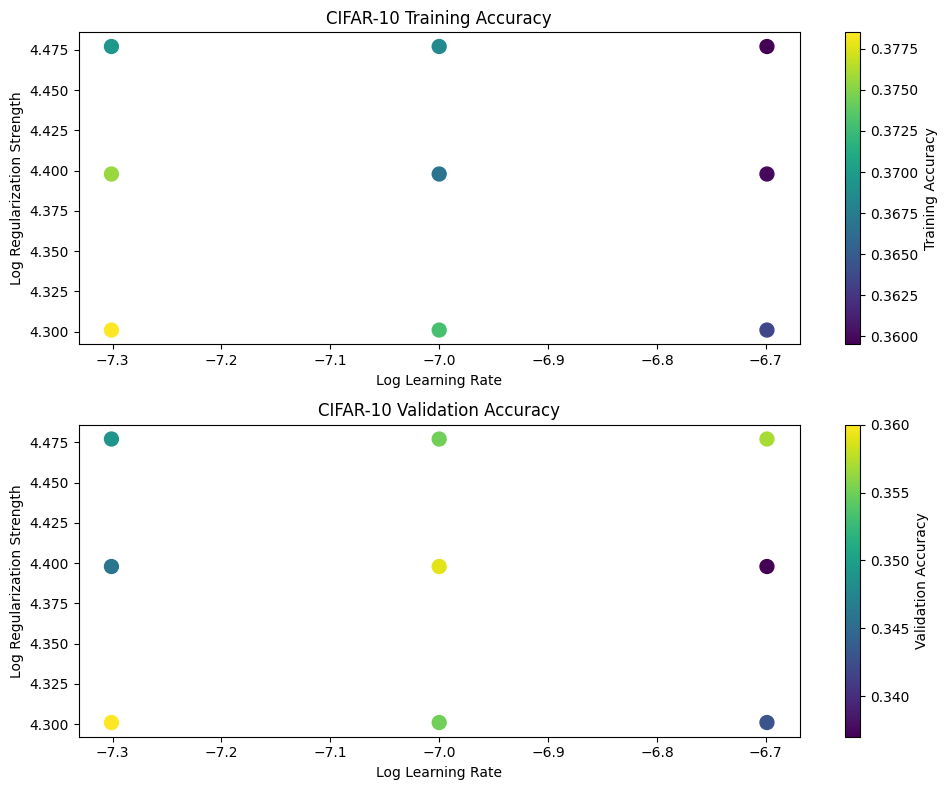

In [106]:
# Visualize the cross-validation results
import math
import matplotlib.pyplot as plt


x_scatter = [math.log10(x[0]) for x in results]  # log of learning rates
y_scatter = [math.log10(x[1]) for x in results]  # log of regularization strengths

# plot training accuracy
marker_size = 100  # Adjust marker size as necessary
colors = [results[x][0] for x in results]  # Training accuracy
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap='viridis')
plt.colorbar(label='Training Accuracy')
plt.xlabel('Log Learning Rate')
plt.ylabel('Log Regularization Strength')
plt.title('CIFAR-10 Training Accuracy')


# plot validation accuracy
colors = [results[x][1] for x in results]  # Validation accuracy
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap='viridis')
plt.colorbar(label='Validation Accuracy')
plt.xlabel('Log Learning Rate')
plt.ylabel('Log Regularization Strength')
plt.title('CIFAR-10 Validation Accuracy')

plt.tight_layout()
plt.show()


In [110]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)



linear SVM on raw pixels final test set accuracy: 0.386000


Shape of W: (3075, 10)
Truncating weights from shape (3074, 10) to (3072, 10)


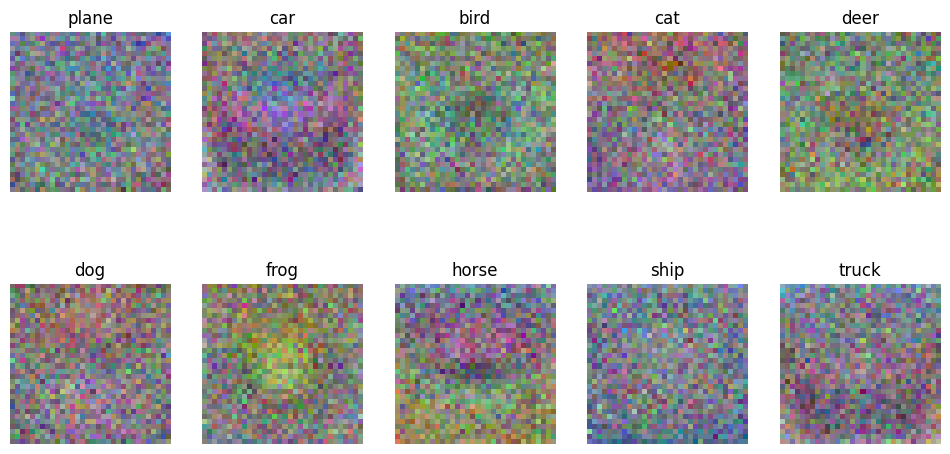

In [114]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.

print("Shape of W:", best_svm.W.shape)


# Strip out the bias and ensure proper dimensions
w = best_svm.W[:-1, :]  # Remove the bias term

# Check if the weights have the correct shape for visualization
if w.shape[0] == 32 * 32 * 3:
    w = w.reshape(32, 32, 3, 10)  # Reshape to (32, 32, 3, 10)
elif w.shape[0] > 32 * 32 * 3:
    # Truncate to match expected image size
    print(f"Truncating weights from shape {w.shape} to {(32 * 32 * 3, 10)}")
    w = w[:32 * 32 * 3, :].reshape(32, 32, 3, 10)
else:
    raise ValueError(f"Unexpected weight matrix shape: {w.shape}. Check input dimensions.")

# Normalize the weights to [0, 255] for visualization
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)  # Rescale weights
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])
plt.show()

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look the way that they do.

**Your answer:** *fill this in*


1. Linear SVM Nature:

    * The SVM learns a single linear classifier for each class, which acts as a weighted sum of pixel values. This means the weights represent the importance of each pixel in predicting the presence of a specific class.

    * However, because the decision boundaries are linear, the SVM cannot capture complex non-linear features such as shapes, textures, or higher-order patterns that a deep neural network could.


2. Raw Pixel Input:

    * The weights are derived directly from raw pixel data. Since CIFAR-10 images are small (32x32) and contain complex scenes, the SVM struggles to identify meaningful features at this level. Instead, it assigns weights based on the average pixel differences between classes, leading to the noisy, abstract patterns.


3. Class Overlap:

    * Many CIFAR-10 classes share common background features or have significant visual overlap (e.g., "cat" and "dog" or "ship" and "plane"). The SVM attempts to differentiate these classes but may assign weights to irrelevant regions because it cannot effectively isolate shared or background features.


4. Regularization Effects:

    * The regularization term (L2) in the SVM loss function prevents the weights from becoming too large. This enforces smoothness but may also reduce the ability of the SVM to focus heavily on specific features.


5. Data Complexity vs. Model Simplicity:

  * The CIFAR-10 dataset contains high variability and noise due to its diverse classes and relatively small resolution. A linear model like SVM, which assumes simple linear separability, is fundamentally limited in capturing these complex variations, resulting in weight maps that look noisy and abstract.

Thus, the SVM weights look like noisy, colorful gradients because the model is working directly with raw pixel data and trying to learn linear boundaries between classes. While these weights give some insight into what the SVM focuses on for each class, they’re not interpretable as clear features due to the simplicity of the model and the complexity of the dataset. This highlights why more advanced techniques, like feature extraction or neural networks, are often needed to handle image data effectively.